# 全卷积网络（FCN）

我们可以基于语义分割对图像中的每个像素进行类别预测。全卷积网络（fully convolutional network，FCN）采用卷积神经网络实现了从图像像素到像素类别的变换 [1]。与之前介绍的卷积神经网络有所不同，全卷积网络通过转置卷积（transposed convolution）层将中间层特征图的高和宽变换回输入图像的尺寸，从而令预测结果与输入图像在空间维（高和宽）上一一对应：给定空间维上的位置，通道维的输出即该位置对应像素的类别预测。

先导入实验所需的包或模块

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys,os
import_path=!cd ..&&cd
sys.path.append(import_path[0])

from mxnet import gluon, image, init, nd, gpu
from mxnet.gluon import data as gdata, loss as gloss, model_zoo, nn
import numpy as np
import d2lzh as d2l
import cloudpickle as pkl

print("导入模块成功")

导入模块成功


# 读取数据
使用DataLoader加载自定义的数据集HandDataset

In [29]:
crop_size, batch_size, colormap2label = (320, 480), 32, nd.zeros(256**3)
for i, cm in enumerate(d2l.hand_colormap):
    colormap2label[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i

feature_dir = "1_train_rgb"
label_dir = "2_train_mask"

num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(
    d2l.HandDataset(feature_dir, label_dir, crop_size, colormap2label,3500,3000), batch_size,
    shuffle=True, last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(
    d2l.HandDataset(feature_dir, label_dir, crop_size, colormap2label,1000,7000), batch_size,
    last_batch='discard', num_workers=num_workers)


开始读取图像...
当前文件夹为:D:\computer vision\data\1_train_rgb
照片总数为:0
读取完毕
开始读取图像...
当前文件夹为:D:\computer vision\data\2_train_mask
照片总数为:0
读取完毕
read 0 examples
开始读取图像...
当前文件夹为:D:\computer vision\data\1_train_rgb
照片总数为:0
读取完毕
开始读取图像...
当前文件夹为:D:\computer vision\data\2_train_mask
照片总数为:0
读取完毕
read 0 examples


在有些文献中，转置卷积也被称为分数步长卷积（fractionally-strided convolution）[2]。


## 构造模型

我们在这里给出全卷积网络模型最基本的设计。如图9.11所示，全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times 1$卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。模型输出与输入图像的高和宽相同，并在空间位置上一一对应：最终输出的通道包含了该空间位置像素的类别预测。

![全卷积网络](../img/fcn.svg)

下面我们使用一个基于ImageNet数据集预训练的ResNet-18模型来抽取图像特征，并将该网络实例记为`pretrained_net`。可以看到，该模型成员变量`features`的最后两层分别是全局最大池化层`GlobalAvgPool2D`和样本变平层`Flatten`，而`output`模块包含了输出用的全连接层。全卷积网络不需要使用这些层。

In [11]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)
print(pretrained_net.features, pretrained_net.output)

# 下面我们创建全卷积网络实例net。它复制了pretrained_net实例成员变量features里除去最后两层的所有层以及预训练得到的模型参数
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=True, use_global_stats=False, in_channels=3)
  (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
  (3): Activation(relu)
  (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (5): HybridSequential(
    (0): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, 

In [6]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)

num_classes = 2
net.add(nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16,
                           strides=32))

net[-1].initialize(init.Constant(bilinear_kernel(num_classes, num_classes,
                                                 64)))
net[-2].initialize(init=init.Xavier())

## 训练模型
现在可以开始训练模型了。这里的损失函数和准确率计算与图像分类中的并没有本质上的不同。因为我们使用转置卷积层的通道来预测像素的类别，所以在SoftmaxCrossEntropyLoss里指定了axis=1（通道维）选项。此外，模型基于每个像素的预测类别是否正确来计算准确率。

In [4]:
ctx = d2l.try_all_gpus()
loss = gloss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1,
                                                      'wd': 1e-3})
d2l.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=5)
print("Finsh trainning successfully!")

training on [cpu(0)]
epoch 1, loss 0.0363, train acc 0.986, test acc 0.990, time 3670.0 sec
epoch 2, loss 0.0291, train acc 0.988, test acc 0.990, time 3815.2 sec
epoch 3, loss 0.0269, train acc 0.989, test acc 0.991, time 3841.9 sec
epoch 4, loss 0.0255, train acc 0.990, test acc 0.991, time 3841.5 sec
epoch 5, loss 0.0245, train acc 0.990, test acc 0.991, time 3807.3 sec
Finsh trainning successfully!


### 训练结果
#### 1500张图片  
training on [cpu(0)]  
epoch 1, loss 0.1323, train acc 0.959, test acc 0.988, time 1474.4 sec  
epoch 2, loss 0.0547, train acc 0.978, test acc 0.982, time 1548.7 sec  
epoch 3, loss 0.0461, train acc 0.981, test acc 0.985, time 1748.1 sec  
epoch 4, loss 0.0422, train acc 0.983, test acc 0.986, time 1394.0 sec  
epoch 5, loss 0.0395, train acc 0.984, test acc 0.989, time 1375.1 sec  

### 序列化该网络

In [2]:
net_filename = "hand_segmentation_net.pkl"
net_filepath = os.path.join(d2l.ROOT_DIR, "model",net_filename)
with open(net_filepath,"wb") as net_f:
    pkl.dump(net,net_f)
print("Save net successfully")

NameError: name 'net' is not defined

## 预测像素类别

在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。

In [26]:
def predict(img):
    X = test_iter._dataset.normalize_image(img)
    X = X.transpose((2, 0, 1)).expand_dims(axis=0)
    pred = nd.argmax(net(X.as_in_context(ctx[0])), axis=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

In [27]:
# 为了可视化每个像素的预测类别，我们将预测类别映射回它们在数据集中的标注颜色。
def label2image(pred):
    colormap = nd.array(d2l.hand_colormap, ctx=ctx[0], dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

测试数据集中的图像大小和形状各异。由于模型使用了步幅为32的转置卷积层，当输入图像的高或宽无法被32整除时，转置卷积层输出的高或宽会与输入图像的尺寸有偏差。为了解决这个问题，我们可以在图像中截取多块高和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向计算。这些区域的并集需要完整覆盖输入图像。当一个像素被多个区域所覆盖时，它在不同区域前向计算中转置卷积层输出的平均值可以作为softmax运算的输入，从而预测类别。

简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为$320\times480$的区域：只有该区域用来预测。对于输入图像，我们先打印截取的区域，再打印预测结果，最后打印标注的类别。

# 预测结果
### 验证集
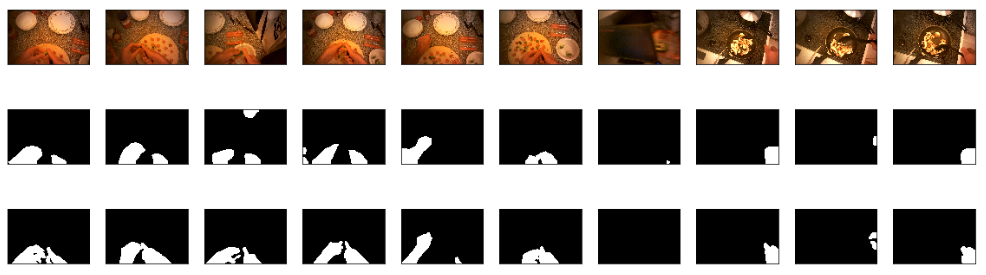
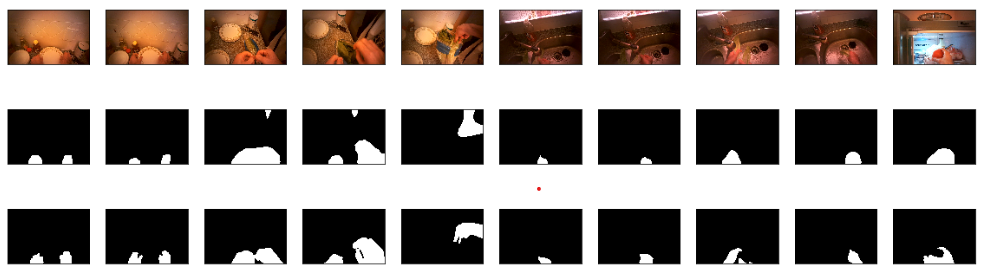

In [21]:
ctx = d2l.try_all_gpus()
feature_dir = "1_train_rgb"
label_dir = "2_train_mask"
if os.listdir(os.path.join(d2l.ROOT_DIR,"data",feature_dir))==[] or os.listdir(os.path.join(d2l.ROOT_DIR,"data",label_dir))==[]  :
    raise Exception("没有正确的放置图片的位置")
test_images, test_labels = d2l.read_features_and_labels(feature_dir = feature_dir, label_dir = label_dir, size = 20,index = 870)
n, imgs = 10, []
for i in range(n):
    crop_rect = (0, 0, 480, 320)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n);

Exception: 没有正确的放置图片的位置

### 测试集
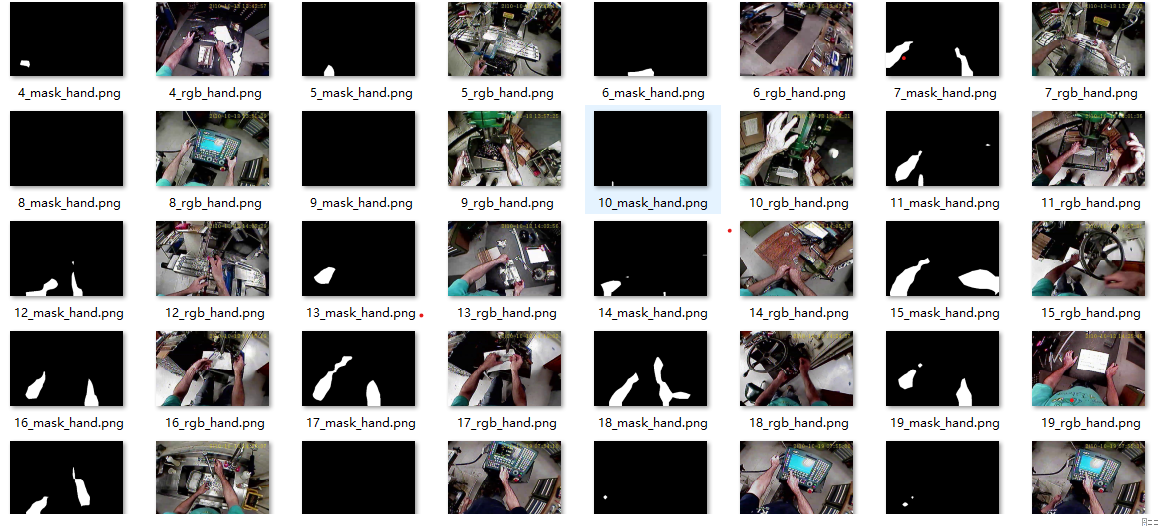

开始读取图像...
当前文件夹为:D:\computer vision\data\3_test_rgb
照片总数为:10
读取完毕


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D68219C1D0>,
      dtype=object)

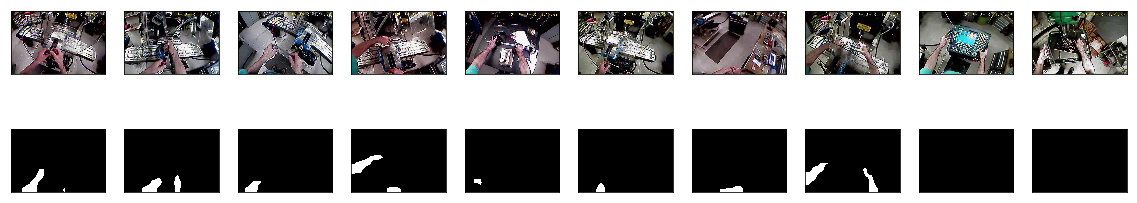

In [36]:
test_dir = "3_test_rgb"
result_dir="test_rgb_and_mask"#你的文件目录
result_dir= os.path.join(d2l.ROOT_DIR, result_dir) 
pictures=os.listdir(os.path.join(d2l.ROOT_DIR,"data",test_dir))
if pictures == []:
    raise Exception("没有正确的放置图片的位置")
num_picture = 10 #图片数量
index_picture = 0 #图片索引
test_images2, _= d2l.read_images(test_dir, num_picture, index_picture)
crop_rect = (0, 0, 480, 320)
images=[]
for i in range(num_picture):
    
    X = image.fixed_crop(test_images2[i], *crop_rect)
    plt.imsave(os.path.join(result_dir,"{}_rgb_hand.png".format(i)),X.asnumpy(),cmap="brg")
    pred = label2image(predict(X))
    images += [X, pred]
    plt.imsave(os.path.join(result_dir,"{}_mask_hand.png".format(i)),pred.asnumpy(),cmap="gray")
 
    

d2l.show_images(images[::2]+images[1::2],2,10)


### 我的测试集
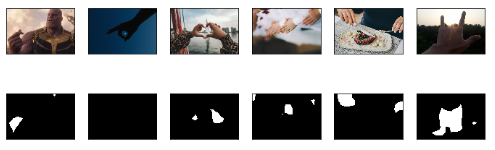
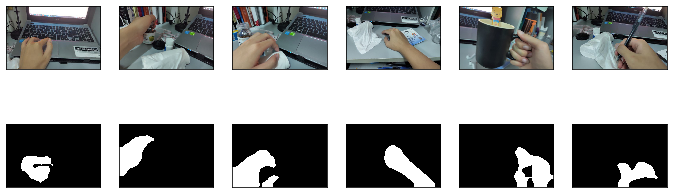

开始读取图像...
当前文件夹为:D:\Machine Learning\d2l-zh\data\4_mytest
照片总数为:12
读取完毕


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C682807C18>,
      dtype=object)

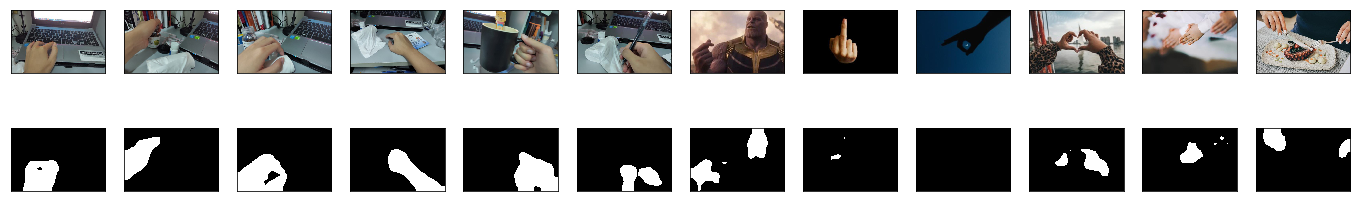

In [11]:
test_dir = "4_mytest"
n = 12
test_images3, _= d2l.read_images(test_dir, n, 0)
crop_rect = (0, 0, 480, 320)
images=[]
for i in range(n):
    
    X = image.fixed_crop(test_images3[i], *crop_rect)
    pred = label2image(predict(X))
    images += [X, pred]
    

d2l.show_images(images[::2]+images[1::2],2,n)